## Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.regression.linear_model as sm
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

## Data & cleaning

Data are from the 1994 Canadian Survey of Labour and Income Dynamics in the province of Ontario. Data were prepared by the Institute for Social Research at York University, and are available at: https://vincentarelbundock.github.io/Rdatasets/datasets.html

Wage data are in $/hour from all jobs. Language refers to respondents' preferred language.

The objective in this notebook is to model wage earners' hourly wages. "Wage earners" are the rows without "NaN" values in their wages column. (Salaried employees' hourly wages were estimated with hours worked, yearly income).

In [2]:
df = pd.read_csv('SLID.csv')
df.head()

,Unnamed: 0,wages,education,age,sex,language
0,1,10.56,15.0,40,Male,English
1,2,11.00,13.2,19,Male,English
2,3,NaN,16.0,49,Male,Other
3,4,17.76,14.0,46,Male,Other
4,5,NaN,8.0,71,Male,English


Objectives:
  * Remove Unnamed index column
  * Change sex to binary (F=0)
  * Create k-1 (2) dummies for language
  * Add intercept for statsmodels' OLS
  * Create subsample of the original dataset (df, n=7425) without ANY NaN values (df1, n=3987), and another where at least the wage data are available (df2, n=4147)

In [3]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

df['sex'] = np.where(df['sex'] == 'Female', 0, 1)

df['En'] = np.where(df['language'] == 'English', 1, 0)
df['Fr'] = np.where(df['language'] == 'French', 1, 0)

df['c'] = 1

df1 = df.dropna()
df2 = df[pd.notnull(df['wages'])]

df1.head()

,wages,education,age,sex,language,En,Fr,c
0,10.56,15.0,40,1,English,1,0,1
1,11.00,13.2,19,1,English,1,0,1
3,17.76,14.0,46,1,Other,0,0,1
5,14.00,16.0,50,0,English,1,0,1
8,8.20,15.0,31,1,English,1,0,1


## Analysis

Objectives:
 * Verify multicollinearity will not be an issue in OLS
 * Analyze distributions of wages, education, age, sex and language in both df1 df2
   * Verify that df1 adequately represents the wage-earner sub-sample (df2)
   * Verify that variables have enough variance to explain variance in wages 

Multicollinearity not a significant issue, especially given that our standard errors will be low, given the large sample size.

In [4]:
# Exog, endog
X, y = df1[['c', 'education', 'age', 'sex', 'En', 'Fr']], df1['wages']

# Display largest correlation each exog variable has with another exog variable
corr = X.corr().replace(1, 0)
corr.max()[1:]

education    0.098751
age          0.014390
sex          0.022363
En           0.098751
Fr           0.022363
dtype: float64

Wages: 

* Large concentration at \$7/hr, reflecting Ontario's 1994 minimum wage of \$6.85, and (probably) rounding on the part of firms or survey respondents.
* Distributions are largely identical between non-missing-data sample (df1) and df2.

[]

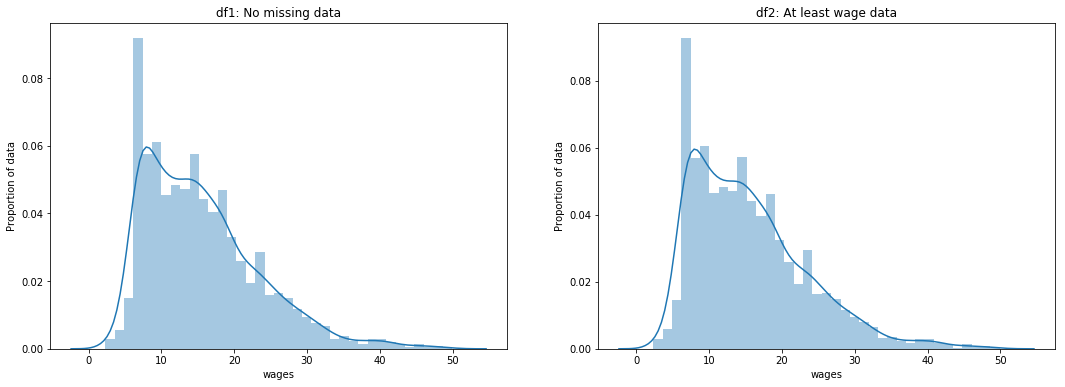

In [5]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
sn.distplot(df1.wages)
plt.title('df1: No missing data')
plt.ylabel('Proportion of data')

plt.subplot(1, 2, 2)
sn.distplot(df2.wages)
plt.title('df2: At least wage data')
plt.ylabel('Proportion of data')

plt.plot()

Education:

* Nearly identical

[]

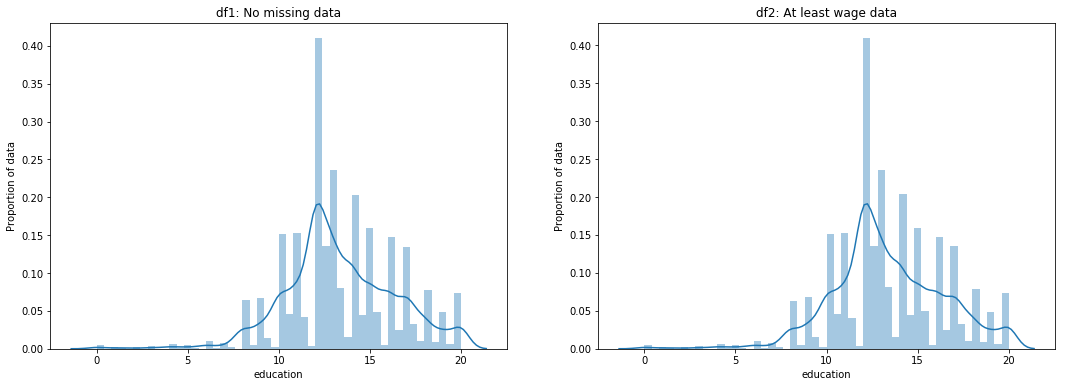

In [6]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
sn.distplot(df1.education)
plt.title('df1: No missing data')
plt.ylabel('Proportion of data')

plt.subplot(1, 2, 2)
sn.distplot(df2.education.dropna())
plt.title('df2: At least wage data')
plt.ylabel('Proportion of data')

plt.plot()

Age:

* Nearly identical

[]

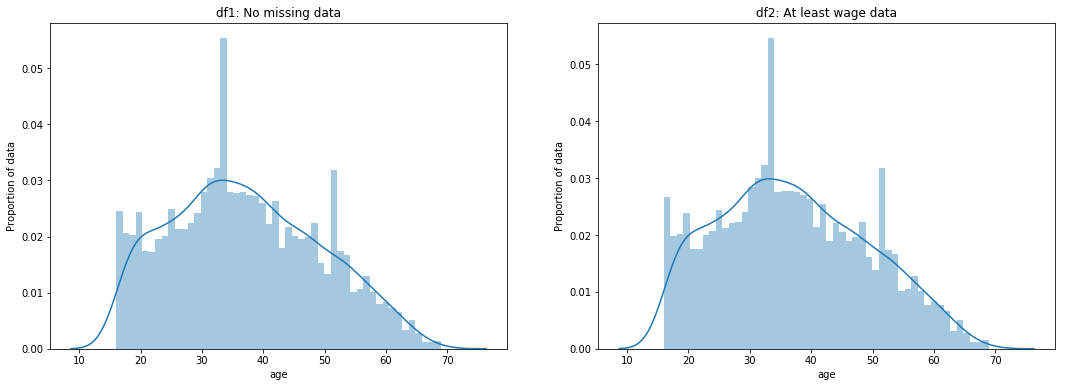

In [7]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
sn.distplot(df1.age, 50)
plt.title('df1: No missing data')
plt.ylabel('Proportion of data')

plt.subplot(1, 2, 2)
sn.distplot(df2.age.dropna(), 50)
plt.title('df2: At least wage data')
plt.ylabel('Proportion of data')

plt.plot()

Gender:
* Both near gender parity

In [8]:
print('\n df1 mean sex:', round(df1.sex.mean(), 3), '\n df2 mean sex :', round(df2.sex.mean(), 3))


 df1 mean sex: 0.498 
 df2 mean sex : 0.499


Language preference:

* Distributions are similar, but English comprises over 80% of data, French 6%, Other 12%. These data are unlikely to provide any explanatory value for wages.

In [9]:
En1 = (len(df1[df1['language'] == 'English'])/len(df1))*100
Fr1 = (len(df1[df1['language'] == 'French'])/len(df1))*100
Oth1 = (len(df1[df1['language'] == 'Other'])/len(df1))*100

En2 = (len(df2[df2['language'] == 'English'])/len(df2))*100
Fr2 = (len(df2[df2['language'] == 'French'])/len(df2))*100
Oth2 = (len(df2[df2['language'] == 'Other'])/len(df2))*100

df1: English, French, Other

In [10]:
round(En1, 2), round(Fr1, 2), round(Oth1, 2)

(81.36, 6.5, 12.14)

df2: English, French, Other

In [11]:
round(En2, 2), round(Fr2, 2), round(Oth2, 2)

(80.18, 6.41, 12.06)

Conclusions:
   * Multicollinearity is not a problem
   * Non-null data provide good representation of wage-earner data.
   * Langauge preference should not be included in regression

* Removing language from exog

In [12]:
X = X.drop(labels=['En', 'Fr'], axis =1)

## Model

Regressing wages via OLS on:
  * constant
  * education
  * age
  * sex
 

OLS model

In [13]:
Results = sm.OLS(y, X).fit().summary()
Results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  wages   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     561.5
Date:                Tue, 21 May 2019   Prob (F-statistic):          2.34e-304
Time:                        17:49:42   Log-Likelihood:                -13178.
No. Observations:                3987   AIC:                         2.636e+04
Df Residuals:                    3983   BIC:                         2.639e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c             -7.8705      0.609    -12.920      0.000      -9.065      -6.676
education      0.9154      0.035     26.449      0.000       0.848       0.983
age            0.2555      0.009     29.505      0.000       0.239       0.273
sex            3.4545      0.209     16.521      0.000       3.045       3.864
==============================================================================
Omnibus:                      596.435   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1267.766
Skew:                           0.891   Prob(JB):                    5.11e-276
Kurtosis:                       5.111   Cond. No.                         240.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion

Conclusions:
   * Approximately 30% of the variance in Ontarian wage-earner's reported income in 1994 is explained by their variance in education, age and sex.
   * Education level and age have significant positive effects on wages at a 99% significance level
   * Sex is estimated to have a significant positive impact on wages at a 99% significance level
   * "Becoming male" is estimated to increase the average female Ontarian's wages by \$3.50 per hour in 1994 Canadian dollars, approximately \$2.60 in 1994 USD, or \$4.50 per hour in 2019 USD, holding education and age constant.
   * This partial effect of \$3.50 CAD is approximately equal to the expected increase in hourly wages from attending an extra 4 years of schooling (\$3.66 CAD), holding age and gender constant.

Critiques:
   * More data, such as the prevailing wage rates for each type of worker surveyed, would greatly improve this model's capacity to isolate the effects education, age or sex on wages - though age and education can be expected to capture some of the industry-based variation in wage.
   
   
   * A linear model assumes a constant partial effect on y  in x, which is not a suitable assumption for analyzing education data - 4 years of graduate school are not equivalent to 4 years of undergraduate, or 4 years of highschool. Finishing one's Senior year of college (and graduating) means more than finishing one's Sophomore year.
   
      * Adding graduated/didn't-graduate dummy variables, splitting the data on secondary/tertiary/post-graduate education levels, or the use of non-linear models like random forests might be effective methods of accounting for this dynamic.